In [1]:
import tensorflow as tf

# Import MNIST data (Numpy format)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST-data/", False, one_hot=True)

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/scipy/__init__.py:144: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


Extracting ../MNIST-data/train-images-idx3-ubyte.gz
Extracting ../MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST-data/t10k-labels-idx1-ubyte.gz


In [ ]:
# Parameters
learning_rate = 0.01
num_steps = 1000
batch_size = 64
display_step = 100

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

sess = tf.Session()

# Create a dataset tensor from the images and the labels
dataset = tf.data.Dataset.from_tensor_slices(
    (mnist.train.images, mnist.train.labels))
# Automatically refill the data queue when empty
dataset = dataset.repeat()
# Create batches of data
dataset = dataset.batch(batch_size)
# Prefetch data for faster consumption
dataset = dataset.prefetch(batch_size)

# Create an iterator over the dataset
iterator = dataset.make_initializable_iterator()
# Initialize the iterator
sess.run(iterator.initializer)

# Neural Net Input (images, labels)
X, Y = iterator.get_next()

In [ ]:
# -----------------------------------------------
# THIS IS A CLASSIC CNN (see examples, section 3)
# -----------------------------------------------
# Note that a few elements have changed (usage of sess run).

# Create model
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 32 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out


# Because Dropout have different behavior at training and prediction time, we
# need to create 2 distinct computation graphs that share the same weights.

# Create a graph for training
logits_train = conv_net(X, n_classes, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights, but has
# different behavior for 'dropout' (not applied).
logits_test = conv_net(X, n_classes, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_train, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Run the initializer
sess.run(init)

# Training cycle
for step in range(1, num_steps + 1):
    
    # Run optimization
    sess.run(train_op)
        
    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        # (note that this consume a new batch of data)
        loss, acc = sess.run([loss_op, accuracy])
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Optimization Finished!")

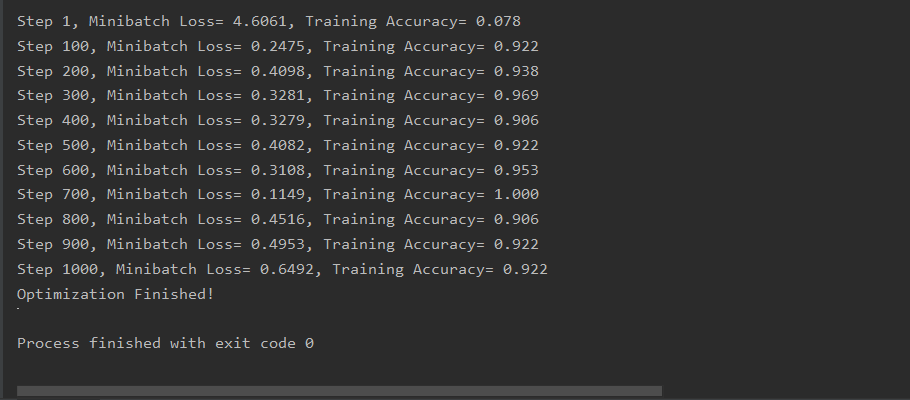